# Orthogonal Fisher divergence analysis
This notebook computes the orthogonal Fisher divergence for all subspaces, datasets, pretrained models, and cutoff times. It then plots the thresholds as a function of cutoff time and computes the correct times for different choices of divergence threshold.

Precomputed jsons with Fisher divergences are already provided. To plot the thresholds and compute cutoff times, execute only the cells in the second part of the notebook. Execute all cells to recompute the divergences.

In [5]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import numpy as np
import os, sys, json
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import tqdm
import seaborn
from sklearn.decomposition import PCA
sns = seaborn
def downsample(x):
    return torch.nn.AvgPool2d(2, stride=2, padding=0)(x)
def upsample(x):
    x = x.view(-1, *x.shape[-3:])
    B, _, R, _ = x.shape
    return x.reshape(B, 3, R, 1, R, 1).repeat(1, 1, 1, 2, 1, 2).reshape(B, 3, 2*R, 2*R)
def repeat(func, x, n):
    for _ in range(n):
        x = func(x)
    return x
import pandas as pd

In [6]:
sys.path.append('./..')
from models import utils as mutils
from models import ncsnpp
from models.ema import ExponentialMovingAverage
import losses
from utils import save_checkpoint, restore_checkpoint
import sde_lib

In [7]:
def subspace_divergence(loader, config, score_fn, std, times, num_batches=1, num_intervals=5):
    df = {'t': [], 'err_norm': [], 'gauss_norm': [], 'score_norm': []}
    beta_min, beta_max = config.model.beta_min, config.model.beta_max 
    sigma_min, sigma_max = config.model.sigma_min, config.model.sigma_max
    if config.data.centered: std = 2 * std
    
    for t in tqdm.tqdm(np.linspace(0, 1, num_intervals+1)):
        if config.training.sde == 'subvpsde':
            beta = beta_min + (beta_max - beta_min)*t
            Beta = 1/2*t**2*(beta_max-beta_min) + t*beta_min
            sigma = 1-np.exp(-Beta)
            alpha = np.exp(-Beta/2)
        elif config.training.sde == 'vesde':
            sigma = sigma_min * (sigma_max/sigma_min) ** t
            alpha = 1          
        for i, X in enumerate(loader):
            if i == num_batches: break
            if type(X) == list: X = X[0]
            X = X.cuda()
            with torch.no_grad():
                if config.data.centered: X = 2 * X - 1.
                X = torch.normal(mean=alpha*X, std=sigma)
                score = score_fn(X, t*torch.ones(X.shape[0], device=X.device))
                score = score - repeat(upsample, repeat(downsample, score, times), times)
                gauss = repeat(upsample, repeat(downsample, X, times), times) - X
                
                gauss = gauss / ((alpha*std)**2 + sigma**2)
                err_norm = ((score - gauss)**2).sum((1, 2, 3))
                gauss_norm = (gauss**2).sum((1, 2, 3))
                score_norm = (score**2).sum((1, 2, 3))

            expected_gauss_norm = 3 * X.shape[-1]**2 * (1-1 / 4**times) / ((alpha*std)**2 + sigma**2)

            gauss_norm /= expected_gauss_norm; err_norm /= expected_gauss_norm; score_norm /= expected_gauss_norm

            df['t'].extend([t]*X.shape[0])
            df['err_norm'].extend(err_norm.cpu().numpy().tolist())
            df['gauss_norm'].extend(gauss_norm.cpu().numpy().tolist())
            df['score_norm'].extend(score_norm.cpu().numpy().tolist())
    return df

In [8]:
def get_model(config, ckpt):
    score_model = mutils.create_model(config)
    optimizer = losses.get_optimizer(config, score_model.parameters())
    ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)
    state = dict(optimizer=optimizer, model=score_model, ema=ema, step=0)
    state = restore_checkpoint(ckpt, state, device=config.device)
    ema.copy_to(score_model.parameters())
    if config.training.sde == 'vesde':
        sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
    elif config.training.sde == 'subvpsde':
        sde = sde_lib.subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
    score_fn = mutils.get_score_fn(sde, score_model, train=False, continuous=True)
    return score_fn

In [9]:
# Numbers from subspace.ipynb
stds = {
    "cifar": {16: 0.07505646805106986, 8: 0.11017048700915723},
    "celeba": {128: 0.034147739617184675, 64: 0.05084107453389564, 32: 0.07347487958749131, 16: 0.1030002890867888, 8: 0.14072510083194403},
    "church": {128: 0.06969019929745306, 64: 0.0883778833712964, 32: 0.10887079373374633, 16: 0.13137195950968375, 8: 0.15799366823221628}
}

# CIFAR

In [8]:
cifar = datasets.CIFAR10('cifar10', train=True, transform=transforms.ToTensor())
cifar_loader = DataLoader(cifar, batch_size=1000, shuffle=False)
base_resolution = 32

In [9]:
from configs.ve import cifar10_ncsnpp_deep_continuous as configs
config = configs.get_config()
score_fn = get_model(config , '../workdir/32.deep/checkpoint_12.pth')

to_save = {}
for resolution in [16, 8]:
    times = int(np.log2(base_resolution / resolution))
    df = subspace_divergence(loader=cifar_loader, config=config, score_fn=score_fn, 
                             std=stds['cifar'][resolution], times=times, num_batches=1, num_intervals=20)
    to_save[resolution] = df
    
with open('cifar10_ncsnpp_deep_continuous.json', 'w') as f:
       f.write(json.dumps(to_save))

100%|███████████████████████████████████████████████████████████████████| 21/21 [00:26<00:00,  1.24s/it]


In [156]:
from configs.ve import cifar10_ncsnpp_continuous as configs
config = configs.get_config()
score_fn = get_model(config , '../workdir/32/checkpoint_24.pth')

to_save = {}
for resolution in [16, 8]:
    times = int(np.log2(base_resolution / resolution))
    df = subspace_divergence(loader=cifar_loader, config=config, score_fn=score_fn, 
                             std=stds['cifar'][resolution], times=times, num_batches=1, num_intervals=20)
    to_save[resolution] = df
    
with open('cifar10_ncsnpp_continuous.json', 'w') as f:
       f.write(json.dumps(to_save))

100%|███████████████████████████████████████████████████████████████████| 21/21 [00:15<00:00,  1.38it/s]


In [184]:
from configs.subvp import cifar10_ddpmpp_deep_continuous as configs
config = configs.get_config()
score_fn = get_model(config, '../workdir/ddpmpp.deep.32/checkpoint_19.pth')

to_save = {}
for resolution in [16, 8]:
    times = int(np.log2(base_resolution / resolution))
    df = subspace_divergence(loader=cifar_loader, config=config, score_fn=score_fn, 
                             std=stds['cifar'][resolution], times=times, num_batches=1, num_intervals=20)
    to_save[resolution] = df
    
with open('cifar10_ddpmpp_deep_continuous.json', 'w') as f:
       f.write(json.dumps(to_save))

100%|███████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.18s/it]


In [186]:
from configs.subvp import cifar10_ddpmpp_continuous as configs
config = configs.get_config()
score_fn = get_model(config, '../workdir/ddpmpp.32/checkpoint_26.pth')

to_save = {}
for resolution in [16, 8]:
    times = int(np.log2(base_resolution / resolution))
    df = subspace_divergence(loader=cifar_loader, config=config, score_fn=score_fn, 
                             std=stds['cifar'][resolution], times=times, num_batches=1, num_intervals=20)
    to_save[resolution] = df
    
with open('cifar10_ddpmpp_continuous.json', 'w') as f:
       f.write(json.dumps(to_save))

100%|███████████████████████████████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


# CelebA

In [6]:
# Numpy file is just a subset of the CelebA-HQ-dataset. Available upon request.
celeba = np.load('celebA-HQ-256.npy')
celeba = torch.tensor(celeba).float()/255
celeba_loader = DataLoader(celeba, batch_size=50, shuffle=False)
base_resolution=256

In [12]:
from configs.ve import celebahq_256_ncsnpp_continuous as configs
config = configs.get_config()
score_fn = get_model(config , '../workdir/celeba256.256/checkpoint_48.pth')

to_save = {}
for resolution in [128, 64, 32, 16, 8]:
    times = int(np.log2(base_resolution / resolution))
    df = subspace_divergence(loader=celeba_loader, config=config, score_fn=score_fn, 
                             std=stds['celeba'][resolution], times=times, num_batches=20, num_intervals=20)
    to_save[resolution] = df
    
with open('celebahq_256_ncsnpp_continuous.json', 'w') as f:
       f.write(json.dumps(to_save))

100%|███████████████████████████████████████████████████████████████████| 21/21 [08:02<00:00, 22.97s/it]


# LSUN Church

In [6]:
# Numpy file is just a subset of the LSUN Church dataset. Available upon request.
church = np.load('lsun-church.npy')
church = torch.tensor(church.transpose(0,3,1,2)).float()/255
church_loader = DataLoader(church, batch_size=50, shuffle=False)
base_resolution=256

In [8]:
from configs.ve import church_ncsnpp_continuous as configs
config = configs.get_config()
score_fn = get_model(config , '../workdir/church.256/checkpoint_126.pth')

to_save = {}
for resolution in [128, 64, 32, 16, 8]:
    times = int(np.log2(base_resolution / resolution))
    df = subspace_divergence(loader=church_loader, config=config, score_fn=score_fn, 
                             std=stds['church'][resolution], times=times, num_batches=20, num_intervals=20)
    to_save[resolution] = df
    
with open('church_ncsnpp_continuous.json', 'w') as f:
       f.write(json.dumps(to_save))

100%|███████████████████████████████████████████████████████████████████| 21/21 [08:03<00:00, 23.03s/it]


# Plot all

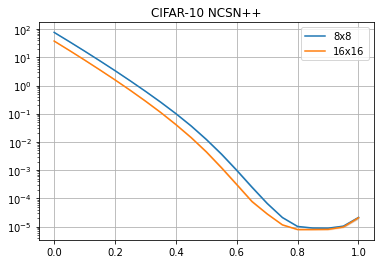

In [30]:
with open('cifar10_ncsnpp_continuous.json') as f:
    data = json.loads(f.read())
sns.lineplot(x=data['8']['t'], y=data['8']['err_norm'], label='8x8')
sns.lineplot(x=data['16']['t'], y=data['16']['err_norm'], label='16x16')
plt.yscale('log')
plt.title('CIFAR-10 NCSN++')
plt.grid()

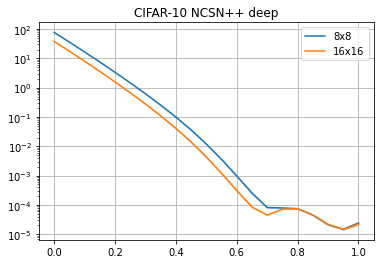

In [31]:
with open('cifar10_ncsnpp_deep_continuous.json') as f:
    data = json.loads(f.read())
sns.lineplot(x=data['8']['t'], y=data['8']['err_norm'], label='8x8')
sns.lineplot(x=data['16']['t'], y=data['16']['err_norm'], label='16x16')
plt.yscale('log')
plt.title('CIFAR-10 NCSN++ deep')
plt.grid()

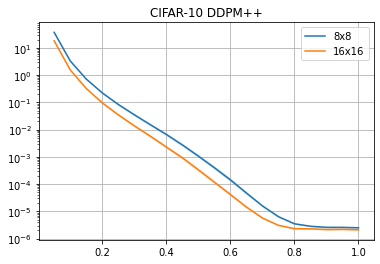

In [32]:
with open('cifar10_ddpmpp_continuous.json') as f:
    data = json.loads(f.read())
sns.lineplot(x=data['8']['t'], y=data['8']['err_norm'], label='8x8')
sns.lineplot(x=data['16']['t'], y=data['16']['err_norm'], label='16x16')
plt.yscale('log')
plt.title('CIFAR-10 DDPM++')
plt.grid()

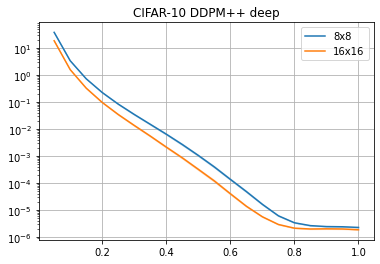

In [33]:
with open('cifar10_ddpmpp_deep_continuous.json') as f:
    data = json.loads(f.read())
sns.lineplot(x=data['8']['t'], y=data['8']['err_norm'], label='8x8')
sns.lineplot(x=data['16']['t'], y=data['16']['err_norm'], label='16x16')
plt.yscale('log')
plt.title('CIFAR-10 DDPM++ deep')
plt.grid()

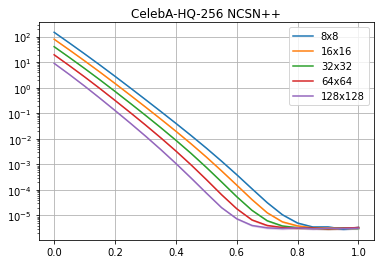

In [34]:
with open('celebahq_256_ncsnpp_continuous.json') as f:
    data = json.loads(f.read())
sns.lineplot(x=data['8']['t'], y=data['8']['err_norm'], label='8x8')
sns.lineplot(x=data['16']['t'], y=data['16']['err_norm'], label='16x16')
sns.lineplot(x=data['32']['t'], y=data['32']['err_norm'], label='32x32')
sns.lineplot(x=data['64']['t'], y=data['64']['err_norm'], label='64x64')
sns.lineplot(x=data['128']['t'], y=data['128']['err_norm'], label='128x128')
plt.yscale('log')
plt.title('CelebA-HQ-256 NCSN++')
plt.grid()

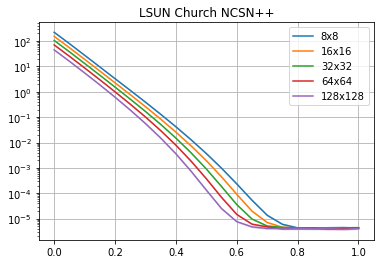

In [35]:
with open('church_ncsnpp_continuous.json') as f:
    data = json.loads(f.read())
sns.lineplot(x=data['8']['t'], y=data['8']['err_norm'], label='8x8')
sns.lineplot(x=data['16']['t'], y=data['16']['err_norm'], label='16x16')
sns.lineplot(x=data['32']['t'], y=data['32']['err_norm'], label='32x32')
sns.lineplot(x=data['64']['t'], y=data['64']['err_norm'], label='64x64')
sns.lineplot(x=data['128']['t'], y=data['128']['err_norm'], label='128x128')
plt.yscale('log')
plt.title('LSUN Church NCSN++')
plt.grid()

## Figure shown in the paper

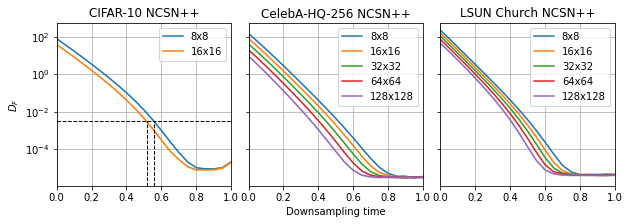

In [36]:
with open('cifar10_ncsnpp_continuous.json') as f:
    data = json.loads(f.read())
fig,axs = plt.subplots(1,3,sharex=False,sharey=True,figsize=(10,3),gridspec_kw = {'wspace':0.1, 'hspace':0})
ax=axs[0]
sns.lineplot(x=data['8']['t'], y=data['8']['err_norm'], label='8x8', ax=ax)
sns.lineplot(x=data['16']['t'], y=data['16']['err_norm'], label='16x16', ax=ax)

ax.set_title('CIFAR-10 NCSN++')
ax.set_ylabel('$D_F$')
ax.axhline(3e-3, ls='--', color='k', lw=1)
ax.axvline(0.558, 0, 0.4, ls='--', color='k', lw=1)
ax.axvline(0.516, 0, 0.4, ls='--', color='k', lw=1)
ax.set_xlim(0, 1)
ax.grid()

with open('celebahq_256_ncsnpp_continuous.json') as f:
    data = json.loads(f.read())
ax=axs[1]
sns.lineplot(x=data['8']['t'], y=data['8']['err_norm'], label='8x8', ax=ax)
sns.lineplot(x=data['16']['t'], y=data['16']['err_norm'], label='16x16', ax=ax)
sns.lineplot(x=data['32']['t'], y=data['32']['err_norm'], label='32x32', ax=ax)
sns.lineplot(x=data['64']['t'], y=data['64']['err_norm'], label='64x64', ax=ax)
sns.lineplot(x=data['128']['t'], y=data['128']['err_norm'], label='128x128', ax=ax)
ax.set_title('CelebA-HQ-256 NCSN++')
ax.set_xlim(0, 1)
ax.grid()

with open('church_ncsnpp_continuous.json') as f:
    data = json.loads(f.read())
ax=axs[2]
sns.lineplot(x=data['8']['t'], y=data['8']['err_norm'], label='8x8', ax=ax)
sns.lineplot(x=data['16']['t'], y=data['16']['err_norm'], label='16x16', ax=ax)
sns.lineplot(x=data['32']['t'], y=data['32']['err_norm'], label='32x32', ax=ax)
sns.lineplot(x=data['64']['t'], y=data['64']['err_norm'], label='64x64', ax=ax)
sns.lineplot(x=data['128']['t'], y=data['128']['err_norm'], label='128x128', ax=ax)
ax.set_yscale('log')
ax.set_title('LSUN Church NCSN++')
ax.set_xlim(0, 1)
ax.grid()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Downsampling time')
plt.savefig('fisher.pdf', bbox_inches='tight')

# Compute cutoff times

In [37]:
def cutoff(data, dim, thresh):
    df = pd.DataFrame(data[dim]).groupby('t').mean()
    x = np.linspace(0, 1, 1001)
    y = np.exp(np.interp(x, df.index, np.log(df['err_norm'])))
    return x[np.argwhere(y < thresh).min()]

In [38]:
for js in [
    'cifar10_ncsnpp_continuous.json',
    'cifar10_ncsnpp_deep_continuous.json',
    'cifar10_ddpmpp_continuous.json',
    'cifar10_ddpmpp_deep_continuous.json'
]:
    with open(js) as f:
        data = json.loads(f.read())
    for dim in ['8', '16']:
        print(js, dim)
        for thresh in [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]:
            t_c = cutoff(data, dim, thresh)
            print(thresh, t_c)

cifar10_ncsnpp_continuous.json 8
0.0001 0.685
0.0003 0.644
0.001 0.6
0.003 0.558
0.01 0.509
0.03 0.46
cifar10_ncsnpp_continuous.json 16
0.0001 0.641
0.0003 0.601
0.001 0.557
0.003 0.516
0.01 0.466
0.03 0.41600000000000004
cifar10_ncsnpp_deep_continuous.json 8
0.0001 0.6920000000000001
0.0003 0.644
0.001 0.599
0.003 0.557
0.01 0.508
0.03 0.459
cifar10_ncsnpp_deep_continuous.json 16
0.0001 0.644
0.0003 0.602
0.001 0.557
0.003 0.515
0.01 0.465
0.03 0.41500000000000004
cifar10_ddpmpp_continuous.json 8
0.0001 0.617
0.0003 0.5650000000000001
0.001 0.504
0.003 0.446
0.01 0.376
0.03 0.31
cifar10_ddpmpp_continuous.json 16
0.0001 0.559
0.0003 0.506
0.001 0.447
0.003 0.387
0.01 0.32
0.03 0.259
cifar10_ddpmpp_deep_continuous.json 8
0.0001 0.616
0.0003 0.5640000000000001
0.001 0.503
0.003 0.444
0.01 0.375
0.03 0.309
cifar10_ddpmpp_deep_continuous.json 16
0.0001 0.559
0.0003 0.504
0.001 0.442
0.003 0.383
0.01 0.317
0.03 0.258


In [39]:
print('CELEBA 64')
with open('celebahq_256_ncsnpp_continuous.json') as f:
    data = json.loads(f.read())
    for thresh in [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]:
        t_c = cutoff(data, '64', thresh)
        print(thresh, t_c)
        
print('LSUN CHURCH 64')
with open('church_ncsnpp_continuous.json') as f:
    data = json.loads(f.read())
    for thresh in [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]:
        t_c = cutoff(data, '64', thresh)
        print(thresh, t_c)

CELEBA 64
0.0001 0.535
0.0003 0.494
0.001 0.449
0.003 0.405
0.01 0.355
0.03 0.307
LSUN CHURCH 64
0.0001 0.54
0.0003 0.507
0.001 0.47000000000000003
0.003 0.434
0.01 0.392
0.03 0.35000000000000003
